In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
sys.path.insert(0, '../src/py-oeis/')

In [3]:
import oeis.etl.extract as extract
import oeis.etl.features as feats
import oeis.viz.plotting as plotting

# Prepare training data

In [4]:
seqs = extract.load_sequences()

In [5]:
features = extract.load_features()

In [6]:
poss_dec = (
    features.loc[
        (features.logmax <= 1.0) & 
        (features.nonneg == 1.0) & 
        (features.uniq == 10)
    ]
)

In [7]:
dec_seq = {k:seqs[k] for k in poss_dec.index}

In [8]:
len(poss_dec)

10502

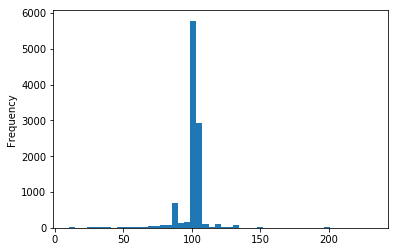

In [9]:
poss_dec.length.plot(kind='hist', bins=50);

In [10]:
print(poss_dec.length.describe().to_string())

count    10502.000000
mean        99.747858
std         10.871887
min         10.000000
25%         99.000000
50%         99.000000
75%        105.000000
max        232.000000


In [11]:
PAD = 120
for k, v in dec_seq.items():
    d = (PAD - len(v))
    if d >= 0:
        dec_seq[k] = v + [np.NaN]*d
    else:
        dec_seq[k] = v[:PAD]

In [12]:
dec = pd.DataFrame(dec_seq).T
dec['tag'] = 1.0

In [13]:
rand_dec = pd.DataFrame(np.random.randint(0,9, size=(len(dec), PAD)))
rand_dec['tag'] = 0.0

In [30]:
data = pd.concat([dec, rand_dec])
X, y = data.drop('tag', axis=1).values, data.tag.values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Model

In [22]:
import torch
import torch.nn as nn

from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [57]:
class LSTMClassifier(nn.Module):

    def __init__(self, hidden_dim1, hidden_dim2, batch_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.batch_size = batch_size

        self.lstm = nn.LSTM(1, hidden_dim1)
        self.lstm2hidden = nn.Linear(hidden_dim1, hidden_dim2)
        self.hidden2label = nn.Linear(hidden_dim2, 2)

        self.hidden1 = self.init_hidden1()
        self.hidden2 = self.init_hidden2()

    def init_hidden1(self):
        h0 = Variable(torch.zeros(1, self.batch_size, self.hidden_dim1))
        c0 = Variable(torch.zeros(1, self.batch_size, self.hidden_dim1))
        return (h0, c0)
    
    def init_hidden2(self):
        h0 = Variable(torch.zeros(1, self.batch_size, self.hidden_dim2))
        c0 = Variable(torch.zeros(1, self.batch_size, self.hidden_dim2))
        return (h0, c0)

    def forward(self, sequence):
        lstm_out, self.hidden1 = self.lstm(sequence, self.hidden1)
        h = self.lstm2hidden(lstm_out[-1])
        y  = self.hidden2label(h)
        return y

In [58]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [ ]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [60]:
hidden_dim1 = 50
hidden_dim2 = 2
sequence_len = PAD
learning_rate = 0.01
epochs = 50
batch_size = 5

model = LSTMClassifier(hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, batch_size=batch_size)

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

train_loss_ = []
test_loss_ = []
train_acc_ = []
test_acc_ = []

train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)


for epoch in range(epochs):
    optimizer = adjust_learning_rate(optimizer, epoch)

    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    
    for i, (seq, tag) in enumerate(zip(X_train.chunk(len(X_train)//5), y_train.chunk(len(y_train)//5))):
        seq = Variable(seq)
        
        model.zero_grad()
        model.batch_size = len(tag)
        model.hidden1 = model.init_hidden1()
        model.hidden2 = model.init_hidden2()
        output = model(seq.t())
        
        loss = loss_function(output, Variable(tag))
        loss.backward()
        optimizer.step()
    

        _, predicted = torch.max(output.data, 1)
        total_acc += (predicted == tag).sum()
        total += len(tag)
        total_loss += loss.data[0]

    train_loss_.append(total_loss / total)
    train_acc_.append(total_acc / total)
    
#     ## testing epoch
#     total_acc = 0.0
#     total_loss = 0.0
#     total = 0.0
#     for i, (seq, tag) in enumerate(zip(X_test, y_test)):
#         test_inputs, test_labels = testdata
#         test_labels = torch.squeeze(test_labels)

#         if use_gpu:
#             test_inputs, test_labels = Variable(test_inputs.cuda()), test_labels.cuda()
#         else: test_inputs = Variable(test_inputs)

#         model.batch_size = len(test_labels)
#         model.hidden = model.init_hidden()
#         output = model(test_inputs.t())

#         loss = loss_function(output, Variable(test_labels))

#         # calc testing acc
#         _, predicted = torch.max(output.data, 1)
#         total_acc += (predicted == test_labels).sum()
#         total += len(test_labels)
#         total_loss += loss.data[0]
#     test_loss_.append(total_loss / total)
#     test_acc_.append(total_acc / total)

#     print('[Epoch: %3d/%3d] Training Loss: %.3f, Testing Loss: %.3f, Training Acc: %.3f, Testing Acc: %.3f'
#           % (epoch, epochs, train_loss_[epoch], test_loss_[epoch], train_acc_[epoch], test_acc_[epoch]))

param = {}
param['lr'] = learning_rate
param['batch size'] = batch_size
param['embedding dim'] = embedding_dim
param['hidden dim'] = hidden_dim
param['sentence len'] = sentence_len

result = {}
result['train loss'] = train_loss_
result['test loss'] = test_loss_
result['train acc'] = train_acc_
result['test acc'] = test_acc_
result['param'] = param

RuntimeError: input must have 3 dimensions, got 2